In [330]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [331]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [332]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}

In [333]:
# Build dataset
def build_dataset(words: list[str], print_examples: int = 0) -> tuple[torch.Tensor, torch.Tensor]:
    block_size = 3 # Context length: number of characters taken to predict the next one
    X, Y = [], []
    for i, w in enumerate(words):
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if i < print_examples:
                print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [334]:
X, Y = build_dataset(words, 5)

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [335]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [336]:
# Embedding lookup table
C = torch.randn((27, 2))

In [337]:
# Parameters
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [338]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [339]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [340]:
# Forward pass
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [341]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h)
h.shape

tensor([[ 0.6450,  0.3874, -0.3281,  ..., -0.2250, -0.6497, -0.0922],
        [ 0.5267, -0.9937, -0.9880,  ..., -0.9965,  0.7626, -0.9905],
        [ 0.8720,  0.9320, -0.9903,  ...,  0.6340, -0.9349, -0.8711],
        ...,
        [-0.9902,  0.8810,  0.9845,  ..., -0.7964,  0.9719,  1.0000],
        [-0.9769,  0.9533,  0.9888,  ..., -0.9906,  0.1782,  1.0000],
        [-0.0177, -0.7631, -0.2836,  ..., -1.0000,  0.9871,  0.7714]])


torch.Size([228146, 100])

In [342]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [343]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [344]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(14.6289)

In [345]:
loss = F.cross_entropy(logits, Y)
loss

tensor(14.6289)

In [346]:
for p in parameters:
    p.requires_grad = True

In [347]:
# Learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [348]:
lri = []
lossi = []

for i in range(1000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

8.40001392364502


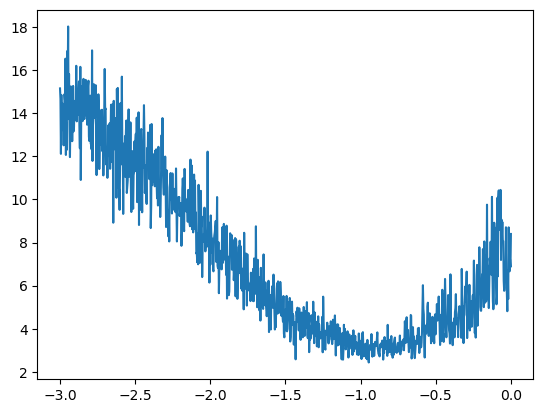

In [349]:
plt.plot(lri, lossi)

In [350]:
for i in range(10000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.586855888366699


In [351]:
# Create the data sets
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.8*len(words))

# Training split (80%)
Xtr, Ytr = build_dataset(words[:n1])

# Dev/validation split (10%)
Xdev, Ydev = build_dataset(words[n1:n2])

# Test split (10%)
Xte, Yte = build_dataset(words[n2:])